# KIN 482E - Programming and Data Science for Kinesiology


## Lecture: Bootstrapping!

## Review

**Inference:** Using a sample to make a conclusion about the wider population

What do the following terms mean:

- population (and population parameter)
- sample
- estimation (and estimate)
- sampling distribution

In [1]:
# load libraries for wrangling and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
# Read in data
airbnb = pd.read_csv("../textbook-chapters/6-Inference/data/listings.csv")

## Review

- Looking at a different question related to the Airbnb data, suppose we are interested in the average rental price per night? 
- The true population mean price per night is \\$154.51 (confirm for yourself). 
- And we know this because we are in the very rare situation where we have access to the entire population (or, we're at least pretending we do). 
- Below we plot the sampling distribution of average rental price per night, using the same techniques we used before to calculate the proportion of rentals that are for entire homes or apartments. 
- This time we calculate the mean price for each sample, instead of a proportion. 

In [3]:
# Set seed for reproducibility
np.random.seed(255)

# Use list comprehension to calculate 20,000 samples of size 40
samples = pd.concat([
    airbnb.sample(40).assign(replicate=n) for n in range(20000)
])
samples

,id,neighbourhood,room_type,accommodates,bathrooms,bedrooms,beds,price,replicate
1868,1869,Downtown Eastside,Entire home/apt,2,1 bath,1,1,200.0,0
20,21,Downtown,Entire home/apt,4,1 bath,1,2,169.0,0
3960,3961,Renfrew-Collingwood,Entire home/apt,3,1 bath,2,2,89.0,0
1234,1235,Shaughnessy,Entire home/apt,2,1 bath,1,1,150.0,0
2602,2603,Killarney,Entire home/apt,6,1 bath,3,3,153.0,0
...,...,...,...,...,...,...,...,...,...
1188,1189,Kitsilano,Entire home/apt,4,1 bath,2,2,100.0,19999
30,31,Grandview-Woodland,Private room,2,1.5 shared baths,1,1,60.0,19999
974,975,Downtown,Entire home/apt,2,1 bath,1,1,120.0,19999
3153,3154,Shaughnessy,Entire home/apt,7,3.5 baths,4,4,398.0,19999


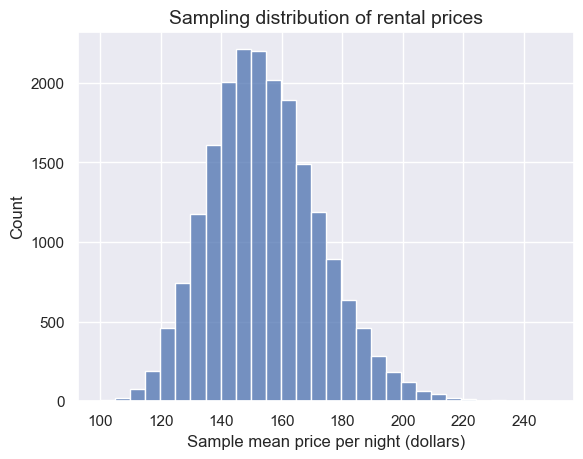

In [4]:
# Calcualte 20,000 sample estimates of the mean price
sample_estimates = (
    samples
    .groupby("replicate")
    ["price"]
    .mean()
    .reset_index()
    .rename(columns={"price": "mean_price"})
)
sample_estimates

# Plot the sampling distribution 
fig, ax = plt.subplots()
sns.histplot(data=sample_estimates, x="mean_price", bins=30, ax=ax)
ax.set_xlabel('Sample mean price per night (dollars)')
ax.set_ylabel('Count')
ax.set_title("Sampling distribution of rental prices", fontsize=14)
plt.show()

## Questions for you

1) How did we generate this figure, and what does it tell us?

2) What happens if I make my sample smaller / larger? Where is the peak of the histogram centered?

3) Can we actually create this figure in a real data analysis problem?

4) What problem does that cause for us?

## Answers
1. generated fig by creating many samples of size N, computing average price, plotting the histogram. This is a visualization of the sampling distribution.
2. If sample size gets larger, the spread of the distribution shrinks (and vice versa). The peak is centered at the true population parameter value.
3. No; in a real data analysis problem we only have one sample to work with (we can't create many samples)
4. This means we cannot visualize the spread, and so have no way of understanding how reliable our point estimate is using just one sample (unless we make lots of assumptions).

## Bootstrapping

We only have one sample... but if it's big enough, the sample looks like the population! This means we can create what's known as a "bootstrap" (or "bootstrapped") distribution that makes the absolute *most* out of our single sample. This is good!

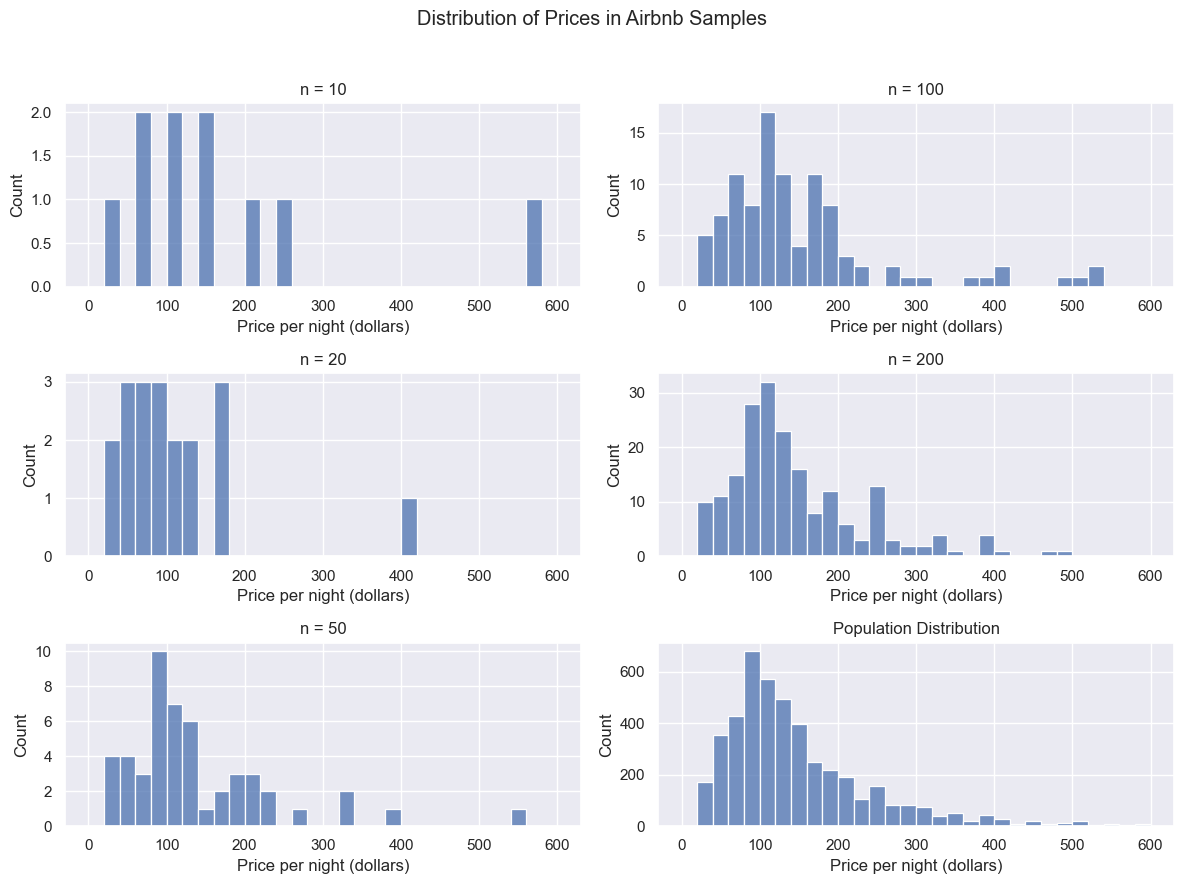

In [5]:
# Plot sample distributions for n = 10, 20, 50, 100, 200
sample_sizes = [10, 20, 50, 100, 200]

# Set up subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
fig.suptitle('Distribution of Prices in Airbnb Samples')

# Plot population distribution
sns.histplot(airbnb['price'], bins=range(0, 601, 20), ax=axs[2, 1])
axs[2, 1].set_title('Population Distribution')
axs[2, 1].set_xlabel('Price per night (dollars)')
axs[2, 1].set_ylabel('Count')

# Plot sample distributions for different sample sizes
for i, sample_n in enumerate(sample_sizes):
    sample = airbnb.sample(sample_n)
    ax = axs[i % 3, i // 3]
    sns.histplot(sample['price'], bins=range(0, 601, 20), ax=ax)
    ax.set_title(f'n = {sample_n}')
    ax.set_xlabel('Price per night (dollars)')
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Let's pretend our *sample* **is** our population. Then we can take many samples from our original sample (called *bootstrap samples*) to give us an approximation of the sampling distribution (the *bootstrap sampling distribution*).

We can use its shape and spread to get the plausible range for our population parameter!

# First, collect your single sample

This is typically what's done in nearly all experiments. You collect your ***single*** sample of rental prices/individuals with diabetes/control subjects/etc from the population of interest (Airbnb rentals, all North American adults with diabetes, all neurotypical adults, etc.). 

In [6]:
# Generate a single sample 
one_sample = airbnb.sample(40)
print(f"The estimated average rental price based on our single sample is {one_sample['price'].mean():.2f}.")

The estimated average rental price based on our single sample is 148.40.


## Generating a single bootstrap sample

1. randomly draw an observation from the original sample (which was drawn from the population)

2. record the observation's value

3. return the observation to the original sample

4. repeat the above the **same number of times as there are observations in the original sample**

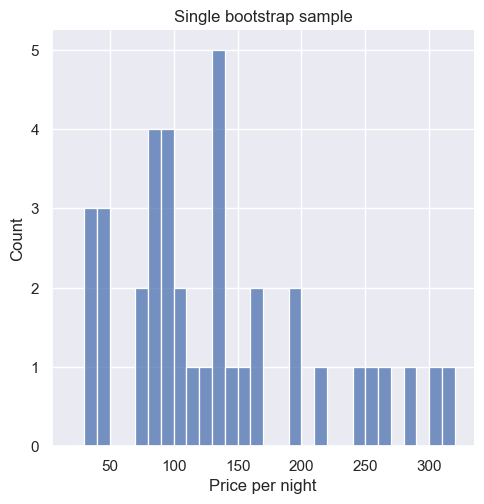

In [7]:
# Calculate and plot a single bootstrap sample
boot1 = one_sample.sample(frac=1,  )
g = sns.displot(data=boot1, x="price", bins=np.arange(20, 321, 10))
g.set(title="Single bootstrap sample", xlabel="Price per night")
plt.show()

What would happen if we sampled *without* replacement? What does that mean?

## Create a *bootstrap* sampling distribution

1. Randomly select an observation from the original sample (e.g., 9 Airbnb listings, 15 individuals post-stroke, 20 healthy young adults, etc.), which was drawn from the population (all Vancouver Airbnb listings, all Canadian adults post-stroke, all healthy, neurotypical adults between the ages of 18-35 across the globe, etc.).
2. Record the observation's value.
3. Replace that observation.
4. Repeat steps 1&ndash;3 (sampling *with* replacement) until you have $n$ observations (where n=# of observations in your single sample from the population), which form a bootstrap sample.
5. Calculate the bootstrap point estimate (e.g., mean, median, proportion, slope, etc.) of the $n$ observations in your bootstrap sample.
6. Repeat steps 1&ndash;5 many times to create a distribution of point estimates (the bootstrap distribution).
7. Calculate the plausible range of values around our observed point estimate.

In [8]:
# We will first create 20,000 bootstrapped samples
boot20000 = pd.concat([
    one_sample.sample(frac=1, replace=True).assign(replicate=n)
    for n in range(20000)
])
boot20000

,id,neighbourhood,room_type,accommodates,bathrooms,bedrooms,beds,price,replicate
964,965,Downtown,Entire home/apt,3,1 bath,2,2,79.0,0
3871,3872,Downtown,Entire home/apt,4,1 bath,1,1,144.0,0
2158,2159,Dunbar Southlands,Entire home/apt,4,1 bath,2,2,150.0,0
4542,4543,Downtown,Private room,2,1 shared bath,1,1,111.0,0
2237,2238,Kitsilano,Entire home/apt,2,1 bath,1,1,130.0,0
...,...,...,...,...,...,...,...,...,...
450,451,Kerrisdale,Private room,2,1 private bath,1,1,79.0,19999
1246,1247,Kitsilano,Entire home/apt,2,1 bath,1,2,87.0,19999
2418,2419,Grandview-Woodland,Entire home/apt,2,1 bath,2,2,165.0,19999
964,965,Downtown,Entire home/apt,3,1 bath,2,2,79.0,19999


### Think

Why are there are 800,000 rows instead of 20,000?

![](slides-img/intro-bootstrap.jpeg)

## Create the bootstrapped sampling distribution

We must calculate our sample statistic (i.e., the mean) for each of the 20,000 samples.

In [9]:
# From our bootstrapped samples, we calculate the mean of each one
boot20000_means = (
    boot20000
    .groupby("replicate")
    ["price"]
    .mean()
    .reset_index()
    .rename(columns={"price": "mean_price"})
)

boot20000_means

,replicate,mean_price
0,0,138.925
1,1,157.825
2,2,145.775
3,3,133.575
4,4,125.200
...,...,...
19995,19995,142.925
19996,19996,130.525
19997,19997,155.100
19998,19998,121.050


In [10]:
# # The following is a more literal interpretation of the sequence of steps
# boot20000_means = pd.DataFrame([
#     one_sample.sample(frac=1, replace=True)["price"]
#     .mean()
#     for n in range(20000)
# ], columns=["mean_price"])
# boot20000_means

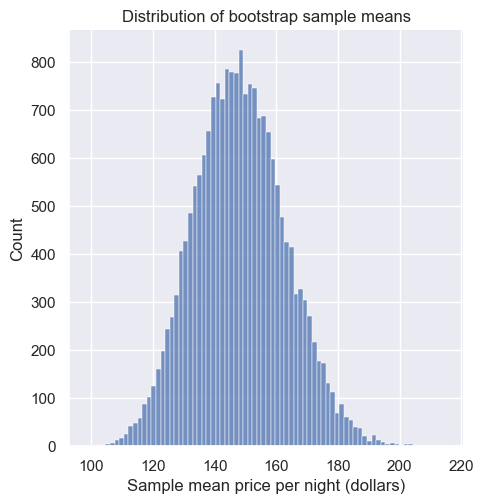

In [11]:
# Plot the bootstrapped sampling distribution
g = sns.displot(data=boot20000_means, x="mean_price")
g.set(title="Distribution of bootstrap sample means",
     xlabel="Sample mean price per night (dollars)")
plt.show()

## Sampling vs bootstrap distribution

Reminder - true population mean = \\$154.51. 


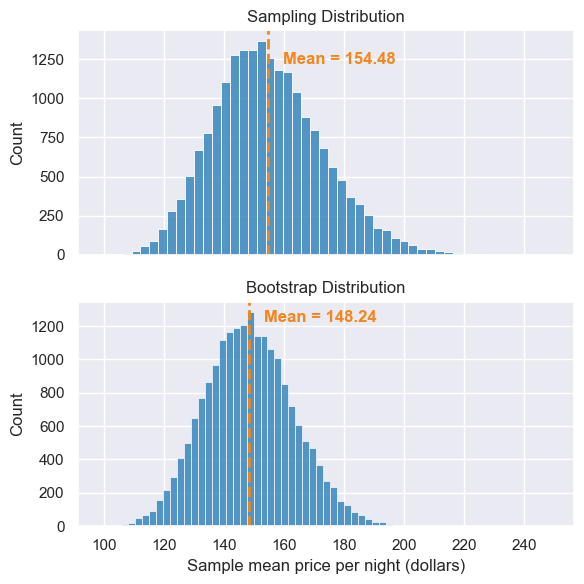

In [12]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# Plot sampling distribution
sns.histplot(sample_estimates['mean_price'], bins=50, ax=axs[0], color="#1f77b4")
axs[0].set_xlabel("Sample mean price per night (dollars)")
axs[0].axvline(x=np.mean(sample_estimates['mean_price']), color="#f58518", linestyle='--', linewidth=2)
axs[0].text(
    x=np.mean(sample_estimates['mean_price'] + 5),
    y=1250,
    s=f"Mean = {np.mean(sample_estimates['mean_price']).round(2)}",
    color="#f58518",
    size=12,
    ha='left',
    va='center',
    fontweight='bold',
)

# Plot bootstrap distribution
sns.histplot(boot20000_means['mean_price'], bins=50, ax=axs[1], color="#1f77b4")
axs[1].set_xlabel("Sample mean price per night (dollars)")
axs[1].axvline(x=np.mean(boot20000_means['mean_price']), color="#f58518", linestyle='--', linewidth=2)
axs[1].text(
    x=np.mean(boot20000_means['mean_price'] + 5),
    y=1250,
    s=f"Mean = {np.mean(boot20000_means['mean_price']).round(2)}",
    color="#f58518",
    size=12,
    ha='left',
    va='center',
    fontweight='bold',
)

# Set titles
axs[0].set_title("Sampling Distribution")
axs[1].set_title("Bootstrap Distribution")

# Adjust layout
plt.tight_layout()
plt.show()

## Two essential points that we can take away from the above histograms

- First, the shape and spread of the true sampling
distribution and the bootstrap distribution are similar; the bootstrap
distribution lets us get a sense of the point estimate's variability. 
- The second important point is that the means of these two distributions are
slightly different. The sampling distribution is centered at
\\$154.51, the population mean value. However, the bootstrap
distribution is centered at the original sample's mean price per night,
\\$148.24. Because we are resampling from the
original sample repeatedly, we see that the bootstrap distribution is centered
at the original sample's mean value (unlike the sampling distribution of the
sample mean, which is centered at the population parameter value).

## Take a minute to appreciate what bootstrapping has done

- With a single sample of 40 observations (from a much, much larger population), we've closely approximated the true sampling distribution
- We know this because we earlier created the sampling distribution from the entire population of observations, something we almost never have access to in real world data science applications. 
- In essence, bootstrapping is a means of simulating many data collections (or experiments), premised only on the assumption that our single sample is representative of the population&mdash;amazing!</d>
- As an aside, a friend who started working for Google after earning his PhD joked that he aced his technical interviews by answering with "I'd use bootstrapping," for any question he didn't have a real answer for. The point being that bootstrapping is almost never a bad idea.

## Using the bootstrap to calculate a plausible range

We can use our bootstrap distribution to calculate the plausible range of values for the population parameter (only requires 1 sample as opposed to thousands of samples from the entire population!):

- $a$ is the 2.5% percentile (the value such that 2.5% of the bootstrap point estiamtes fall below)
- $b$ is the 97.5% percentile (the value such that 97.5% of the bootstrap point estimates fall below)
- the (approximate) *confidence interval* we report is the range from $a$ to $b$

We can report **both** our sample point estimate and the plausible range where we expect our true population quantity to fall. The steps invovled are the following: 

1. Arrange the observations in the bootstrap distribution in ascending order.
2. Find the value such that 2.5\% of observations fall below it (the 2.5\% percentile). Use that value as the lower bound of the interval.
3. Find the value such that 97.5\% of observations fall below it (the 97.5\% percentile). Use that value as the upper bound of the interval.

To do this in Python, we wiill again use the `quantile` function of our DataFrame.
Quantiles are expressed in proportions rather than percentages,
so the 2.5th and 97.5th percentiles
would be quantiles 0.025 and 0.975, respectively.

In [13]:
ci_bounds = boot20000_means["mean_price"].quantile([0.025, 0.975])
ci_bounds 

0.025    120.524375
0.975    178.550000
Name: mean_price, dtype: float64

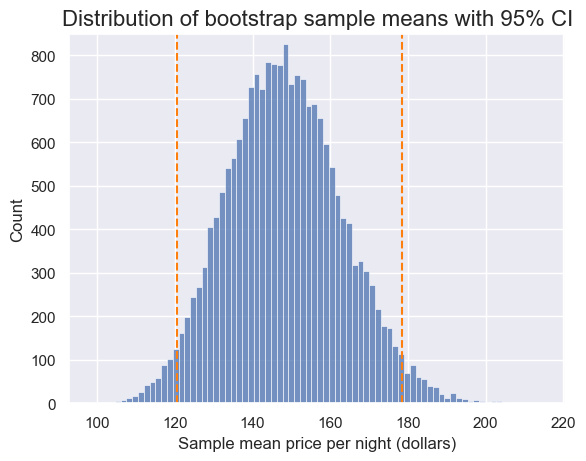

In [14]:
fig, ax = plt.subplots()
sns.histplot(data=boot20000_means, x="mean_price", ax=ax)
ax.set_xlabel("Sample mean price per night (dollars)")
ax.set_ylim(0, 850)
ax.vlines(ci_bounds, 0, ax.get_ylim()[1], color="tab:orange", linestyle="--")
ax.set_title("Distribution of bootstrap sample means with 95% CI", fontsize=16)
plt.show() 

## Go to bootstrapping exercise in textbook chapter!